2343   -1125800000
2344   -1111052006
2345   -1144900000
2346   -1114700000
2347   -1114643006
           ...    
3813   -1110900000
3814   -1110000000
3815   -1105200000
3816   -1104600000
3817   -1101922008
Name: Longitude, Length: 1475, dtype: int64 2343    541700000
2344    530648004
2345    524800000
2346    522600000
2347    521855007
          ...    
3813    541500000
3814    542500000
3815    543000000
3816    542500000
3817    541037092
Name: Latitude, Length: 1475, dtype: int64


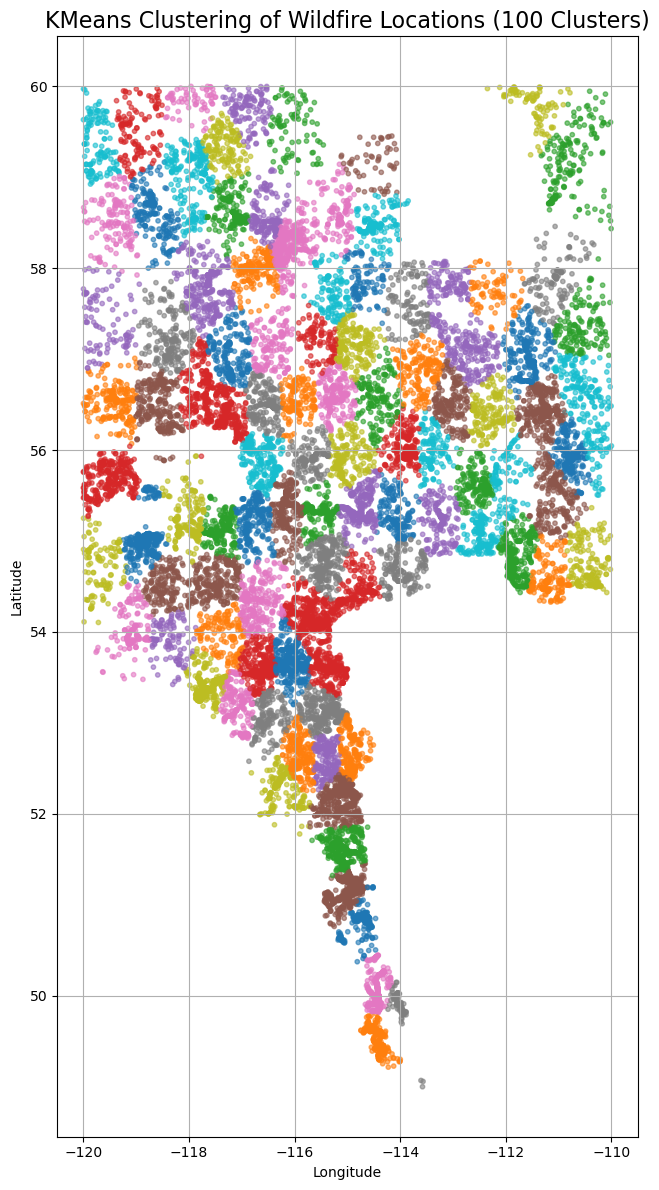

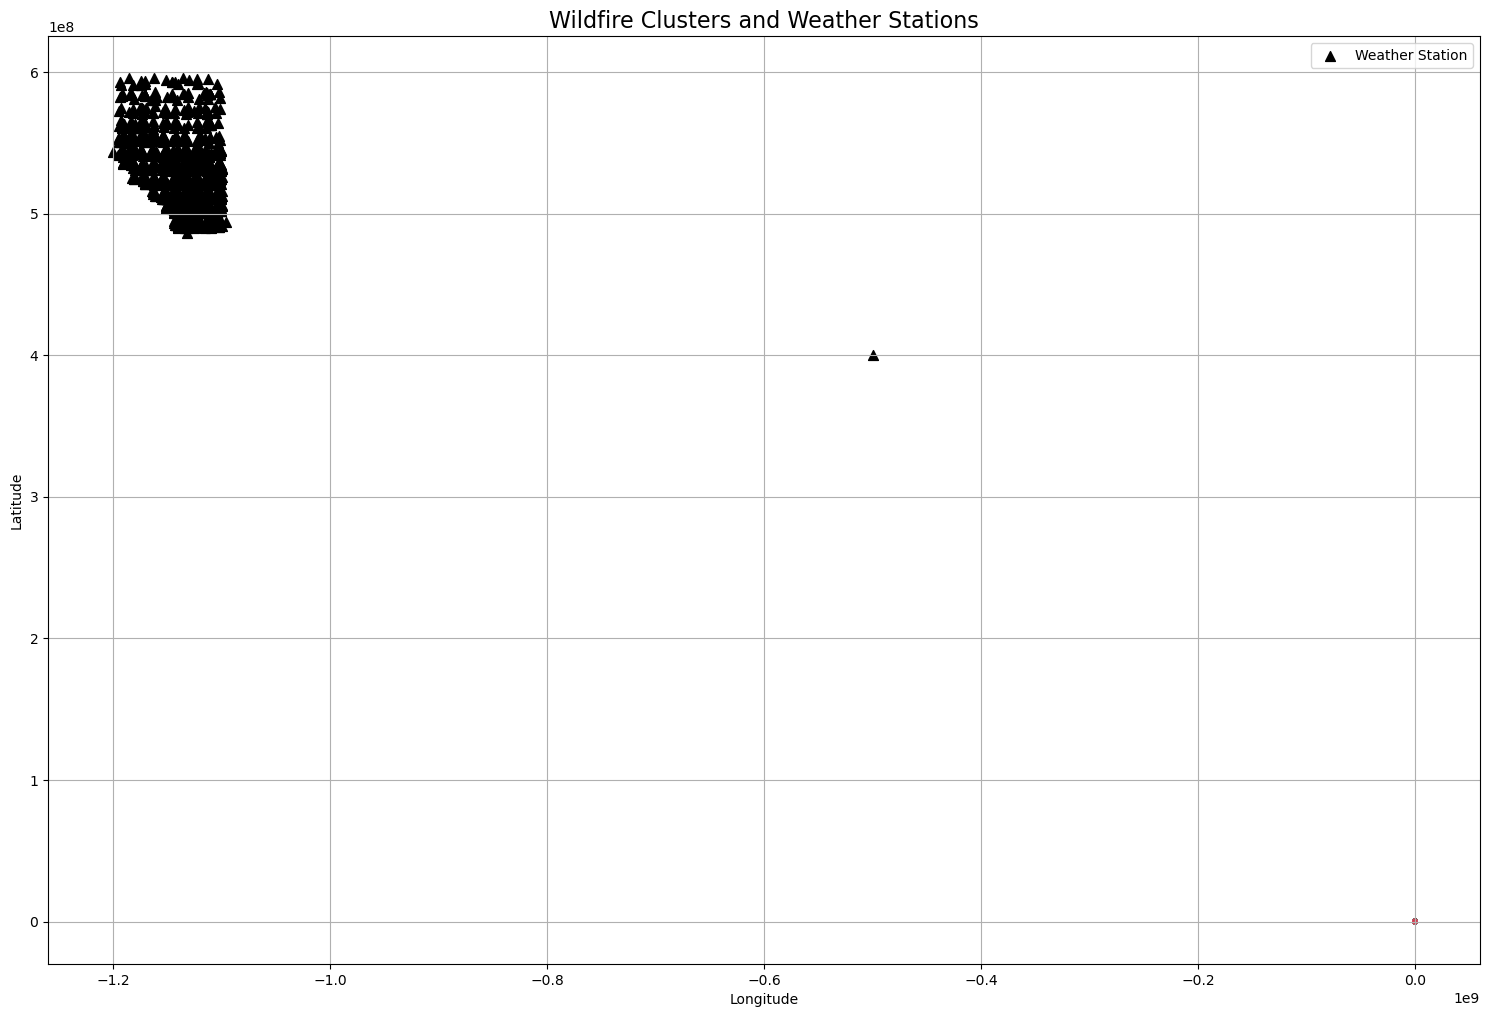

In [13]:
# Re-import required libraries after code execution environment reset
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

alberta_bounds = {
    "lat_min": 48.9,
    "lat_max": 60.0,
    "lon_min": -120.0,
    "lon_max": -110.0
}

# Define the class again
class WildfireWeatherAnalysis:
    def __init__(self, wildfire_file, weather_file):
        self.wildfire_file = wildfire_file
        self.weather_file = weather_file
        self.df = None
        self.clustered_gdf = None
        self.weather_gdf = None

    def load_data(self):
        # Load wildfire data
        if self.wildfire_file.endswith('.xlsx'):
            excel_file = pd.ExcelFile(self.wildfire_file)
            self.df = pd.read_excel(excel_file, sheet_name="2006-2024")
        elif self.wildfire_file.endswith('.csv'):
            self.df = pd.read_csv(self.wildfire_file)
        else:
            raise ValueError("Unsupported wildfire file format")

        # Load weather station data
        weather_df = pd.read_csv(self.weather_file, skiprows=0, quotechar='"')

        # weather_df.columns = [
        #     "Name", "Province", "Climate ID", "Station ID", "WMO ID", "TC ID",
        #     "Latitude", "Longitude", "Lat Raw", "Lon Raw", "Elevation (m)",
        #     "First Year", "Last Year", "HLY First Year", "HLY Last Year",
        #     "DLY First Year", "DLY Last Year", "MLY First Year", "MLY Last Year"
        # ]
        weather_df = weather_df[weather_df["Province"].str.upper() == "ALBERTA"]
        # Filter data within Alberta

        weather_df = weather_df.dropna(subset=["Latitude", "Longitude"])
        # weather_df = weather_df[
        #     (weather_df["Latitude"] >= alberta_bounds["lat_min"]) &
        #     (weather_df["Latitude"] <= alberta_bounds["lat_max"]) &
        #     (weather_df["Longitude"] >= alberta_bounds["lon_min"]) &
        #     (weather_df["Longitude"] <= alberta_bounds["lon_max"])
        # ]
        print(weather_df["Longitude"], weather_df["Latitude"])
        self.weather_gdf = gpd.GeoDataFrame(
            weather_df,
            geometry=gpd.points_from_xy(weather_df["Longitude"], weather_df["Latitude"]),
            crs="EPSG:4326"
        )

    def cluster_wildfires(self, n_clusters=100):
        coords = self.df[['LATITUDE', 'LONGITUDE']].dropna()
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        coords['CLUSTER'] = kmeans.fit_predict(coords)
        self.clustered_gdf = gpd.GeoDataFrame(
            coords,
            geometry=gpd.points_from_xy(coords['LONGITUDE'], coords['LATITUDE']),
            crs="EPSG:4326"
        )

    def plot_clusters(self):
        fig, ax = plt.subplots(figsize=(15, 12))
        self.clustered_gdf.plot(ax=ax, column='CLUSTER', categorical=True, legend=False, markersize=10, alpha=0.6)
        ax.set_title("KMeans Clustering of Wildfire Locations (100 Clusters)", fontsize=16)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_clusters_with_weather(self):
        fig, ax = plt.subplots(figsize=(15, 12))
        self.clustered_gdf.plot(ax=ax, column='CLUSTER', categorical=True, legend=False, markersize=10, alpha=0.6)
        self.weather_gdf.plot(ax=ax, color='black', marker='^', label='Weather Station', markersize=50)
        ax.set_title("Wildfire Clusters and Weather Stations", fontsize=16)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Instantiate and run the analysis
analysis = WildfireWeatherAnalysis(
    wildfire_file="fp-historical-wildfire-data-2006-2024.csv",
    weather_file="StationInventoryEN.csv"
)
analysis.load_data()
analysis.cluster_wildfires(n_clusters=100)
analysis.plot_clusters()
analysis.plot_clusters_with_weather()
